In [1]:
import os
from pathlib import Path
import random
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = "data/cell-nuclei-kaggle/stage1/train/"
TEST_PATH = "data/cell-nuclei-kaggle/stage1/test/"

def stqdm(iterator, **kwargs):
    return tqdm(iterator, bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}', **kwargs)

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

print("Num train examples: {}".format(len(train_ids)))
print("Num test examples: {}".format(len(test_ids)))

Using cuda device
Num train examples: 670
Num test examples: 65


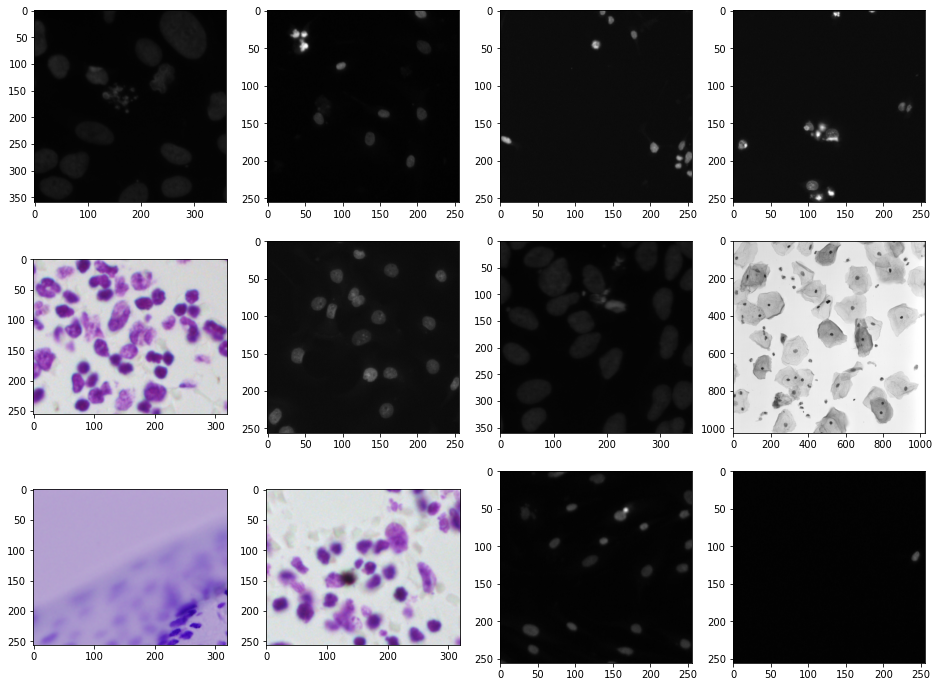

In [2]:
random.seed(906)
rand_ids = random.sample(train_ids, 12)
f, subaxes = plt.subplots(3, 4, figsize=(16, 12))
subaxes = subaxes.flatten()
for i, id_ in enumerate(rand_ids):
    img = imread(TRAIN_PATH + id_ + '/images/' + id_ + '.png')
    subaxes[i].imshow(img)

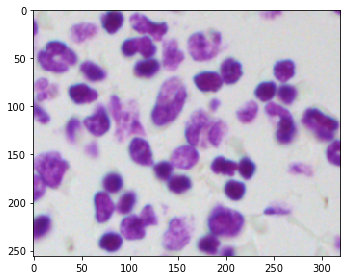

In [3]:
id_ = rand_ids[4]
img = imread(TRAIN_PATH + id_ + '/images/' + id_ + '.png')
imshow(img)

(256, 320)


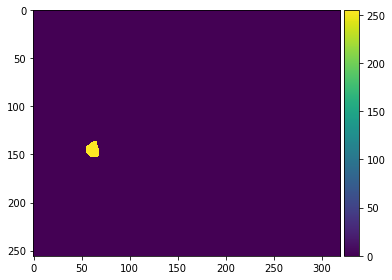

In [4]:
mask_file = next(os.walk(TRAIN_PATH + id_ + '/masks/'))[2][7]
mask = imread(TRAIN_PATH + id_ + '/masks/' + mask_file)
print(mask.shape)
imshow(mask)

In [5]:
raw_base_path = 'data/cell-nuclei-kaggle/stage1/train/'
cache_base_path = 'data/cell-nuclei-kaggle/cache/stage1/train/'
Path(cache_base_path).mkdir(exist_ok=True, parents=True)

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for n, id_ in stqdm(enumerate(train_ids), total=len(train_ids)):
    image_rel_path = id_ + '/images/'
    image_cache_path = cache_base_path + image_rel_path + id_ + '.png'
    if os.path.exists(image_cache_path):
        img = imread(image_cache_path)
    else:
        img = imread(raw_base_path + image_rel_path + id_ + '.png')[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True).astype(np.uint8)
        Path(cache_base_path + image_rel_path).mkdir(parents=True, exist_ok=True)
        imsave(image_cache_path, img)
    X[n] = img
    
    masks_rel_path = id_ + '/masks/'
    mask_cache_path = cache_base_path + masks_rel_path + id_ + '.png'
    if os.path.exists(mask_cache_path):
        mask = np.expand_dims(imread(mask_cache_path), axis=-1)
    else:
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1))
        for mask_file in next(os.walk(raw_base_path + masks_rel_path))[2]:
            mask_ = imread(raw_base_path + masks_rel_path + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        mask = mask.astype(np.uint8)
        Path(cache_base_path + masks_rel_path).mkdir(parents=True, exist_ok=True)
        imsave(mask_cache_path, mask)
    Y[n] = mask.astype(bool)

100%|██████████████████████████████| 670/670 [00:00<00:00, 915.05it/s]                                                                                                        


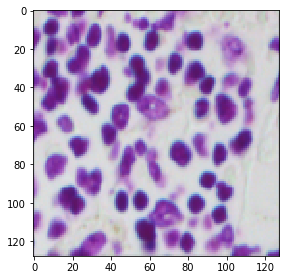

In [6]:
imshow(X[0])

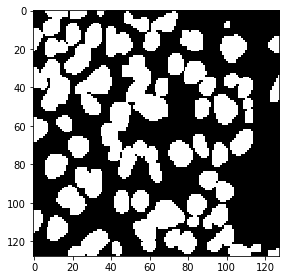

In [7]:
imshow(Y[0].astype(np.uint8) * 255)

In [8]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, max_pool=2):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(max_pool)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, x, c):
        x = self.deconv(x)
        x = self.relu(x)
        x = torch.cat([x, c], dim=1)
        return x

    
class UNet(pl.LightningModule):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.down1 = Down(3, 16, max_pool=1)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 64)
        self.down4 = Down(64, 128)
        self.down5 = Down(128, 256)
        self.up4 = Up(256, 128)
        self.up3 = Up(256, 64)
        self.up2 = Up(128, 32)
        self.up1 = Up(64, 16)
        self.final_conv = nn.Conv2d(35, 1, 1)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        c1 = self.down1(x)
        c2 = self.down2(c1)
        c3 = self.down3(c2)
        c4 = self.down4(c3)
        r = self.down5(c4)
        u4 = self.up4(r, c4)
        u3 = self.up3(u4, c3)
        u2 = self.up2(u3, c2)
        u1 = self.up1(u2, c1)
        out = torch.cat([x, u1], dim=1)
        out = self.final_conv(out)
        out = out.permute(0, 2, 3, 1)
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.forward(x)
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(torch.flatten(y_pred, 1), torch.flatten(y, 1))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x)
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(torch.flatten(y_pred, 1), torch.flatten(y, 1))
        self.log('val_loss', loss)

        
X_train, X_val, Y_train, Y_val = train_test_split(torch.from_numpy(X), torch.from_numpy(Y), test_size=0.2, random_state=609)
X_train = (X_train / 255.).float()
X_val = (X_val / 255.).float()
Y_train = Y_train.float()
Y_val = Y_val.float()

train_data = TensorDataset(X_train, Y_train)
val_data = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_data, batch_size=16)
val_loader = DataLoader(val_data, batch_size=16)

model = UNet()

trainer = pl.Trainer(gpus=1, max_epochs=100)
trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | down1      | Down   | 448   
1 | down2      | Down   | 4.6 K 
2 | down3      | Down   | 18.5 K
3 | down4      | Down   | 73.9 K
4 | down5      | Down   | 295 K 
5 | up4        | Up     | 295 K 
6 | up3        | Up     | 147 K 
7 | up2        | Up     | 36.9 K
8 | up1        | Up     | 9.2 K 
9 | final_conv | Conv2d | 36    
--------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.525     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarni

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --port=8008